In [1]:
import rasterio, rasterio.merge
from rasterio.plot import show

import os
import matplotlib.pyplot as plt
import numpy as np
from util_data_exploration import get_tile_images, reconvert_np_to_rasterio_dataset

## Merge DSM tiles into one image (one-time item, reactivate whenever necessary)
Procedure:
1. Retrieve all items from directory to be merged with
2. Open all items into list
3. Use rasterio.merge to save all into TIFF image for future use

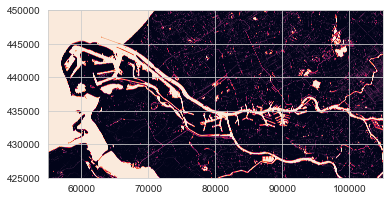

In [2]:
# merge dsm tiles into one unified  (create function later)

path = '../data/DSM/'
dsm_files = [f for f in os.listdir(path) if '.tif' in f.lower()]
# load into list for now
dsm_list = [rasterio.open(f'{path}{name}') for name in dsm_files]

mosaic, mosaic_trans = rasterio.merge.merge(dsm_list)
# f32_inf = 340282346638528859811704183484516925440.00000 # not necessary?
# mosaic[mosaic == f32_inf] = np.nan # ALERT: not necessary!

fig, ax = plt.subplots()
show(mosaic, transform=mosaic_trans,ax=ax)
# plt.savefig('data/test_map.jpg',dpi=1000)
# Save merged map as TIF image (for further reuse), one-time, uncomment when needed
with rasterio.open('../data/rdam_topo_map.tif',mode='w',count=1,
                   width=mosaic.squeeze().shape[1],
                   height=mosaic.squeeze().shape[0],
                   crs=dsm_list[0].crs,
                   transform=mosaic_trans,
                   dtype=dsm_list[0].dtypes[0]) as dest:
    dest.write(mosaic)

## Converting the Topo Map to boolean map for land/water

In [ ]:
## CONVERSION OF TOPO MAP TO LAND/WATER BOOLEAN MAP, SCALED TO SAME FACTOR AS FLOOD MAP
## get rdam bool of land/water = 1/0 and save
rdam_dsm_map = rasterio.open('../data/rdam_topo_map.tif')

# downscale the map to be 100m resolution
rdam_land_bool_map = rdam_dsm_map.read(1) < 3e38    # where 3e38 ~= numerical infinity
downscale_factor = 5  # downscale =
# np.newaxis creates an extra dummy axis because rasterio wants it in 3 dimensions
test_collapse = get_tile_images(rdam_land_bool_map[:,:,np.newaxis],
                                width=downscale_factor, height=downscale_factor)

## AGGREGATE TO NEW RESOLUTION VIA WATER-BOOL METHOD
# since water/land is simply as 1/0,
test_collapse2 = np.sum(test_collapse,axis=(2,3)).squeeze()
# need to filter out again into binary
test_collapse3 = (test_collapse2 > ((downscale_factor * downscale_factor) //2) + 1).astype(int)

sanity_check = False
if sanity_check:
    # Sanity check: to see if the delta affects the accuracy of downsampling
    fitting = []
    binary_bound = range(0,25,1)
    for bound in binary_bound:
        fitting.append(np.sum(test_collapse2 > bound))

    deltas = (fitting-fitting[0])/(test_collapse2.shape[0]*test_collapse2.shape[1])
    plt.scatter(x=binary_bound, y=deltas)

    """ The plot below shows x = 'bound limit for accepting the cell as terrain', and y = 'percentage delta of terrain that would increase if the bound increases'.

    With increasing bound threshold, between 0 <= bound <= 15 the percentage difference is on the order of 0 - 4% (using bound = 0 as a base case). Using the midpoint (25/2 = 12.5) makes for an acceptable bound for aggregation.
    """

In [4]:
# CORRECT AFFINE TRANSFORM AND RECREATE AS DATASET AGAIN
host_map = rdam_dsm_map # original coordinate bounds
# generate new affine transform
test_collapse3_transform = rasterio.transform.from_bounds(
    west=host_map.bounds.left,
    south=host_map.bounds.bottom,
    east=host_map.bounds.right,
    north=host_map.bounds.top,
    width=test_collapse3.shape[1],
    height=test_collapse3.shape[0]
)
# recreate Rasterio Dataset object
test_collapse4 = reconvert_np_to_rasterio_dataset(test_collapse3, transform=test_collapse3_transform, count=1)

In [5]:
# save rasterio dataset object
with rasterio.open('../data/rdam_topo_bool_map.tif', mode='w', count=1,
                   width=test_collapse3.shape[1],
                   height=test_collapse3.shape[0],
                   crs=rdam_dsm_map.crs,
                   transform=test_collapse3_transform,
                   dtype=test_collapse3.dtype) as dest:
    dest.write(test_collapse3[np.newaxis])

In [12]:
# skip the downscaling for the topo bool map, created at raw resolution
rdam_dsm_arr = (rdam_dsm_map.read(1) < 3e38).astype(np.int32)

with rasterio.open('../data/rdam_topo_bool_map_5m.tif', mode='w', count=1,
                   width=rdam_dsm_map.shape[1],
                   height=rdam_dsm_map.shape[0],
                   crs=rdam_dsm_map.crs,
                   transform=rdam_dsm_map.transform,
                   dtype=np.int32) as dest:
    dest.write(rdam_dsm_arr[np.newaxis])

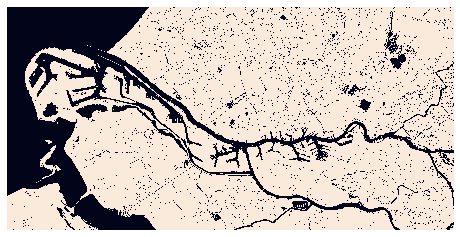

In [10]:
# sanity check plot for raw 5m plot, uncomment as needed
# plt.matshow(rdam_dsm_arr)
# plt.axis('off')
# plt.savefig('../data_exploration/rdam_dsm_arr_5m.jpg', dpi=600)

(55000.0, 105000.0, 425000.0, 450000.0)

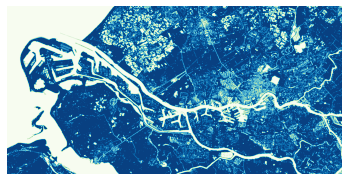

In [15]:
# current objective: plot the new map over the geo maps to see if they make sense
fig, ax = plt.subplots()
show(test_collapse4,ax=ax,cmap='GnBu')
# buurten.plot(ax=ax,
#              **{'alpha':0.6,
#                      'edgecolor':'w',
#                      'facecolor':'lime'
#                      })
plt.axis('off')
# fig.savefig('data/test_map.jpg',dpi=1000)